In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

E0000 00:00:1733662843.671785      13 common_lib.cc:815] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`=local.
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:531


In [6]:
df = pd.read_csv(r'/kaggle/input/dataset-new/Dental-Neural-Network-images/train.csv')

diagnosis_dict_binary = {
    0: 'Normal',
    1: 'Abnormal',
    2: 'Abnormal'
}

diagnosis_dict = {
    0: 'Normal',
    1: 'Abscess',
    2: 'Fracture'
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,images (1) copy 2,0,Normal,Normal
1,images (1) copy 3,0,Normal,Normal
2,images (1) copy 4,0,Normal,Normal
3,images (1) copy 5,0,Normal,Normal
4,images (1) copy,0,Normal,Normal


<Axes: ylabel='type'>

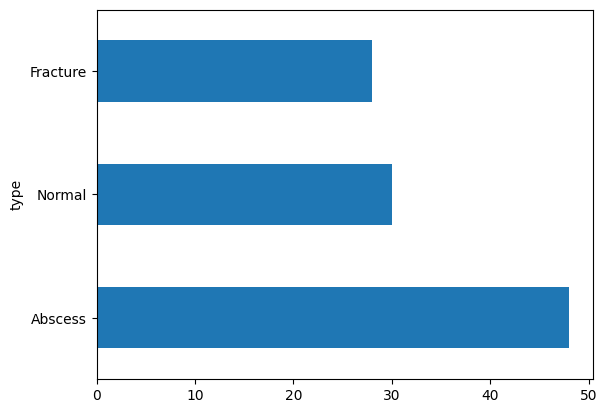

In [7]:
df['type'].value_counts().plot(kind='barh')

In [8]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
Abscess     34
Fracture    20
Normal      20
Name: count, dtype: int64 

For Testing Dataset :
type
Abscess     7
Normal      5
Fracture    4
Name: count, dtype: int64 

For Validation Dataset :
type
Abscess     7
Normal      5
Fracture    4
Name: count, dtype: int64 



In [9]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [10]:
src_dir = r'/kaggle/input/dataset-new/Dental-Neural-Network-images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [11]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 74 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [91]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

Epoch 1/50
3/3 [==============================] - 3s 250ms/step - loss: 0.3659 - acc: 0.8514 - val_loss: 0.7533 - val_acc: 0.3125
Epoch 2/50
3/3 [==============================] - 1s 162ms/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.7423 - val_acc: 0.3125
Epoch 3/50
3/3 [==============================] - 1s 155ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.7187 - val_acc: 0.2500
Epoch 4/50
3/3 [==============================] - 1s 148ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.6808 - val_acc: 0.7500
Epoch 5/50
3/3 [==============================] - 1s 145ms/step - loss: 2.5027e-04 - acc: 1.0000 - val_loss: 0.6504 - val_acc: 0.7500
Epoch 6/50
3/3 [==============================] - 1s 153ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.6475 - val_acc: 0.6875
Epoch 7/50
3/3 [==============================] - 1s 148ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.6731 - val_acc: 0.6875
Epoch 8/50
3/3 [==============================] - 1s 151ms/step - loss: 2.2794e-04 - a

In [92]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model/assets


INFO:tensorflow:Assets written to: 64x3-CNN.model/assets


In [93]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

1/1 [==============================] - 0s 126ms/step - loss: 2.0182 - acc: 0.6875


/tmp/ipykernel_13/1501885792.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


Loss:  2.0181894302368164
Accuracy:  0.6875


In [39]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    print(per)
    if per==0:
        print('Abscess and Fracture Not Detected! Routine dental hygiene is still important.')
    else:
        print('Dental Abscess or an Fracture has been Detected, Please refer to an expert.')

1/1 [==============================] - 0s 119ms/step
[0]
Abscess and Fracture Not Detected! Routine dental hygiene is still important.


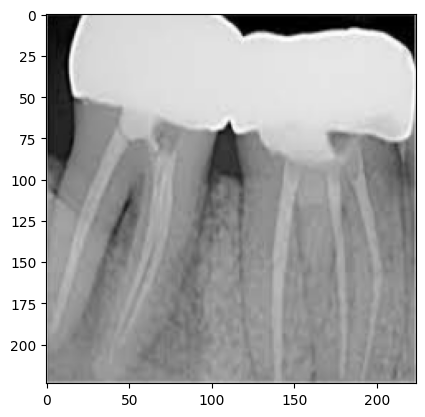

In [90]:
predict_class('/kaggle/input/dataset-new/Dental-Neural-Network-images/Fracture/images.jpeg')